# Do Timestamps Match up?

In [6]:
import imp
import run_analysis as ana
from ximea import xiapi
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import ximea_cam_aquire_save as xim

from time import sleep, time
import pupil_cam_aquire_save as pup
import zmq_socket as zmqs
#import pupil_src.shared_modules.file_methods as pupfm
import threading

## Collect some Images from Eyetracker & Ximea Cameras

***Dont Actually Do this unless you want to spend a bunch of time to go through and find the blinking on and off**

Collect with all 4 cameras (2 ximea, 2 pupil labs) facing a strobing light to determine if on/off times are matched.

In [7]:
collection_mins = 0.5
save_batchsize = 200
pupil_port = 50020 #42715
ncameras = 1

pupil_save_dir_name = '/home/vasha/Desktop/backpack_computer_aquisition/test_timestamps/pupil'
ximea_save_folder_list = ['./test_timestamps']
analysis_folder = './test_timestamps/analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

#Don't actually recapture
recapture=True

In [17]:
if(recapture):
    #start pupil labs aquisition as a spun off thread
    eyetracker_thread = threading.Thread(target=pup.run_pupillabs_aquisition, 
                                            args=(pupil_save_dir_name,
                                                 collection_mins,
                                                 pupil_port))
    eyetracker_thread.daemon = True  # Daemonize threadse
    eyetracker_thread.start()        # Start the execution   

    #run ximea acquision realtime.
    xim.ximea_acquire(ximea_save_folder_list, max_collection_mins=collection_mins, ims_per_file=save_batchsize, num_cameras=ncameras)
else:
    print("Not Actually Recapturing. Assume we already have data")

PUPIL_CAM Connecting to socket at 127.0.0.1:50020 ...
SCENE_CAM Starting Acquisition threads...
Timesync successful.
SCENE_CAM Opening Camera cyPUPIL_CAM Beginning Recording for max 0.5 mins...
/home/vasha/Desktop/backpack_computer_aquisition/test_timestamps/pupil

SCENE_CAM Recording Timestamp Syncronization Pre...
SCENE_CAM Begin Recording for up to 6000 frames...
PUPIL_CAM Finished PupilLabs Aquisition.
SCENE_CAM Reached 6000 frames collected
SCENE_CAM Camera cy Cleanup...
SCENE_CAM Camera cy aquisition finished
SCENE_CAM Finished Aquiring...
SCENE_CAM Saving Timestamp Sync Information...
SCENE_CAM Waiting for Save Queues to Empty...
SCENE_CAM Pipes are Empty. Camera Collection Finished without Interrupt
SCENE_CAM All Finished - Ending Ximea Camera Now.


## Paths for Timestamps Files

In [18]:
#od_ximea_timestamp_path = os.path.join(ximea_save_folder_list[0],'timestamps_od.tsv')
cy_ximea_timestamp_path = os.path.join(ximea_save_folder_list[0],'timestamps_cy.tsv')

#od_ximea_timesync_path = os.path.join(ximea_save_folder_list[0],'timestamp_camsync_od.tsv')
cy_ximea_timesync_path = os.path.join(ximea_save_folder_list[0],'timestamp_camsync_cy.tsv')

#od_pupil_timestamp_path = os.path.join(pupil_save_dir_name,'000','eye0_timestamps.npy')
#os_pupil_timestamp_path = os.path.join(pupil_save_dir_name,'000','eye1_timestamps.npy')


cy missed frames total: 490.0 / 5960 = 8.22%


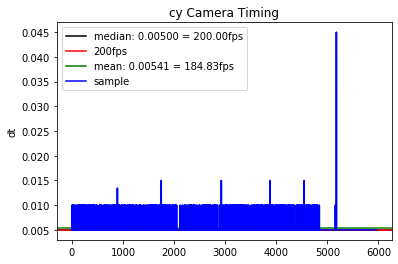

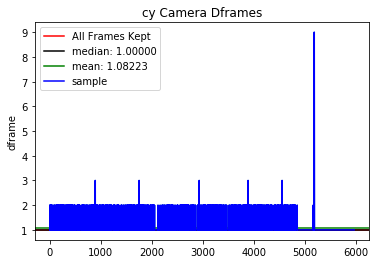

In [19]:
ana.count_missed_frames(cy_ximea_timestamp_path, 'cy')
ana.plot_camera_timing(cy_ximea_timestamp_path, './test_timestamps/timestamps_plot_cy.png', 'cy')
ana.plot_camera_dframe(cy_ximea_timestamp_path, './test_timestamps/timestamps_plot_cy.png', 'cy')

## Convert to unified wall clock time

In [20]:
imp.reload(ana)
#od_ximea_timestamps = ana.convert_ximea_time_to_unix_time(od_ximea_timestamp_path, od_ximea_timesync_path)
cy_ximea_timestamps = ana.convert_ximea_time_to_unix_time(cy_ximea_timestamp_path, cy_ximea_timesync_path)

#od_ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted_od.tsv')
cy_ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted_cy.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(cy_ximea_timestamp_converted_path, cy_ximea_timestamps, fmt='%10.5f', delimiter='\t')

Time Elapsed: 32.49167227745056 seconds
Time Drift pre to post: 0.0004596745494609422 seconds
1574742196.3539987


## Compare Timestamps

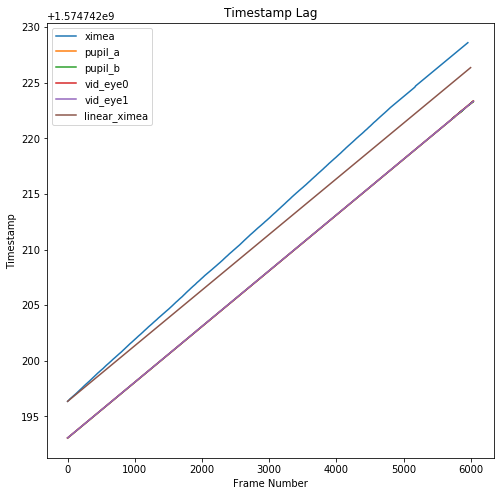

In [22]:
pupil_num='008'

pupil_ts = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'pupil_timestamps.npy'))
pupil_ts_eye_a = pupil_ts[::2]
pupil_ts_eye_b = pupil_ts[1::2]
#pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'gaze_timestamps.npy'))
pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy'))
pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye1_timestamps.npy'))
pupil_annotations = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'annotation_timestamps.npy'))

#ximea timestamps
with open(cy_ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,collection_mins*200*60*0.005, 0.005)+timestamps_ximea[0]
linear_pupil = np.arange(0, collection_mins*200*60*0.005, 0.005)+pupil_ts[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(pupil_ts_eye_a, label='pupil_a')
plt.plot(pupil_ts_eye_b, label='pupil_b')
#plt.plot(pupil_ts_gaze, label='gaze')
plt.plot(pupil_ts_eye0, label='vid_eye0')
plt.plot(pupil_ts_eye1, label='vid_eye1')
plt.plot(linear_ximea, label='linear_ximea')
#plt.plot(linear_pupil, label='linear_pupil')
plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

In [27]:
pupil_ts_eye_a[0],pupil_ts_eye_a[1]

(1574742193.0628781, 1574742193.066811)

In [25]:
timestamps_ximea[0],timestamps_ximea[1], 

(1574742196.359, 1574742196.364)

In [17]:
linear_pupil[0] - pupil_ts_eye_a[0]

0.0

In [20]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

-0.15585708618164062

In [23]:
linear_pupil[400] - pupil_ts_eye_a[400]

-0.002727031707763672

In [25]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

-0.15585708618164062

In [26]:
print(len(linear_ximea))
print(len(pupil_ts_eye_a))


6000
5971


In [27]:
print(len(timestamps_ximea), len(linear_ximea))

5959 6000


In [28]:
timestamps_ximea[0] - linear_ximea[0]

0.0

In [29]:
timestamps_ximea[100] - linear_ximea[100]

0.044970035552978516

In [30]:
timestamps_ximea[1000] - linear_ximea[1000]

0.5659699440002441

In [26]:
timestamps_ximea[23828] - linear_ximea[23828]

2.6085100173950195

In [29]:
len(ximea_ts)

NameError: name 'ximea_ts' is not defined

In [30]:
pupil_ts[0]

1574301576.4886224

In [11]:
pupil_ts[1]

1574301576.4910474

In [12]:
pupil_ts[2]

1574301576.4936295

In [13]:
pupil_ts[3]

1574301576.4960544

In [33]:
timestamps_ximea[0] - pupil_ts_eye0[0]

2.596371650695801

In [34]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

24.291245698928833

In [32]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

24.291245698928833

In [ ]:
timestamps_ximea[0]

In [ ]:
timestamps_ximea[1]

In [ ]:
timestamps_ximea[2]

In [ ]:
print(pupil_ts_eye0[0])
print(pupil_ts_eye1[0])


In [ ]:
pupil_ts_eye0[1]

In [ ]:
pupil_ts_eye0[2]

In [ ]:
timestamps_ximea

In [ ]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'pupil_timestamps.npy'))
pupil_ts_file_eye0 = os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy')
pupil_ts_file_eye1 = os.path.join(pupil_save_dir_name, pupil_num, 'eye1_timestamps.npy')


    
#pupil timestamps
ts_pupil = np.load(pupil_ts)
timestamps_pupil_eye0 = np.load(pupil_ts_file_eye0)
timestamps_pupil_eye1 = np.load(pupil_ts_file_eye1)


plt.plot(ts_pupil,label='pupil')
plt.plot(timestamps_pupil_eye1,label='pupil_eye1')
plt.plot(timestamps_pupil_eye0,label='pupil_eye0')
plt.plot(timestamps_ximea,label='ximea')


## Find Image of Two Ximea Cameras near Turn-off Point

In [32]:
imp.reload(ana)
target_framenum = 1000
target_timestamp = ana.ximea_framenum_to_timestamp(cy_ximea_timestamp_converted_path, target_framenum)

#frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_ximea_timestamp_converted_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_ximea_timestamp_converted_path, target_timestamp)

ts_cy_pre = ana.ximea_framenum_to_timestamp(cy_ximea_timestamp_converted_path, frame_cy-1) #reverse
ts_cy_post = ana.ximea_framenum_to_timestamp(cy_ximea_timestamp_converted_path, frame_cy+1) #reverse


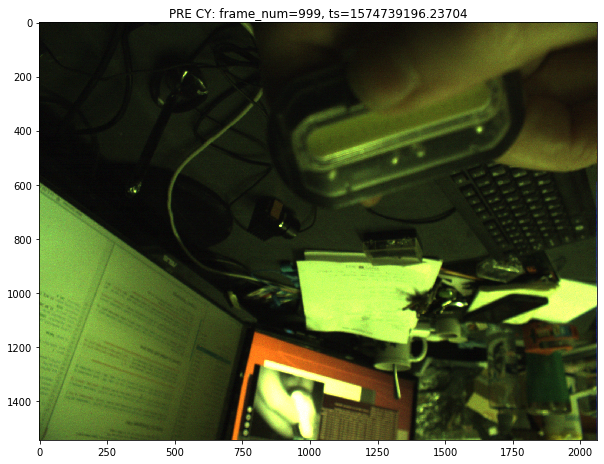

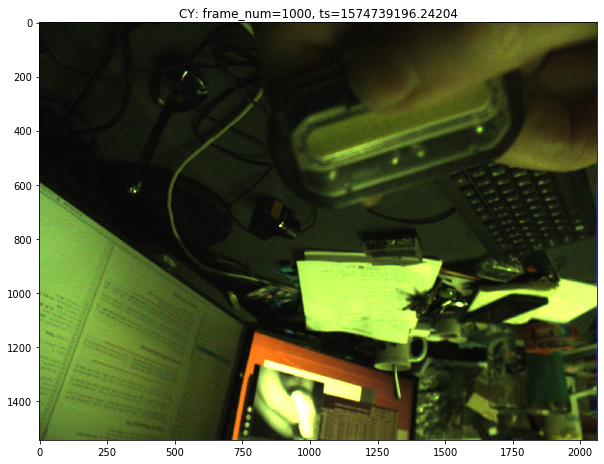

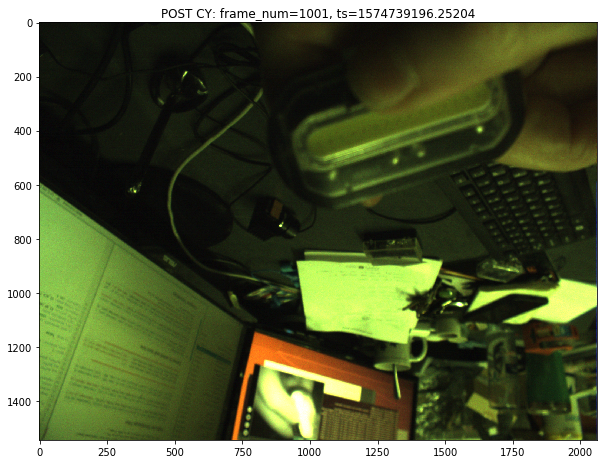

In [33]:
#img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy_pre = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy_post = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[0])

#plt.imshow(img_od)
#plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
#plt.show()
plt.figure(figsize=(10,13))
plt.imshow(img_cy_pre)
plt.title(f'PRE CY: frame_num={frame_cy-1}, ts={ts_cy_pre}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy_post)
plt.title(f'POST CY: frame_num={frame_cy+1}, ts={ts_cy_post}')
plt.show()

## Turn On - OD

In [34]:
# imp.reload(ana)
# img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
# plt.show()

## Turn On - OS

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Find Image of Two Ximea Cameras near Turn-off Point

In [ ]:
imp.reload(ana)
target_timestamp = 5837.48

frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_timestamp_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_timestamp_path, target_timestamp)
#ts_cy = ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy) #reverse

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])

In [ ]:
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
plt.show()
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

## Turn Off - OD

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
plt.show()

## Turn Off - CY

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Turn Off - Pupil Labs Eye 1

Timestamps are syncing up - this seems a bit unexpected. Checking manually it looks like the only happens some of the time. I wonder if it may have something to do with the bandwidth being limited.  

In [35]:
imp.reload(ana)

pupil_ts_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy')
#ana.pupil_framenum_to_timestamp(pupil_file, 120)
pupil_fnum, pupil_timestamp = ana.pupil_timestamp_to_framenum(pupil_ts_file, target_timestamp)
print(f'Target: {target_timestamp}')
print(f'Actual: {pupil_timestamp}')
print(f'Frame: {pupil_fnum}')

Target: 1574739196.24204
Actual: 1574739196.241019
Frame: 1751


In [36]:
pupil_vid_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0.mp4')

frame_pup_pre = ana.pupil_get_frame(pupil_vid_file, pupil_fnum-1)
ts_pup_pre = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum-1)

frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum)
ts_pup = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum)

frame_pup_post = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+1)
ts_pup_post = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+1)

frame_pup_post2 = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+2)
ts_pup_post2 = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+2)


Target Time: 1574739196.24204


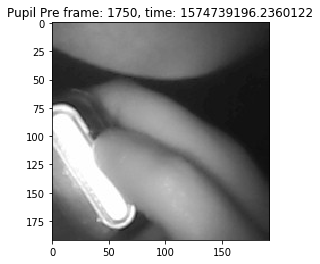

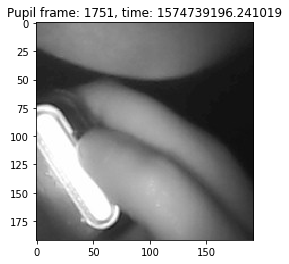

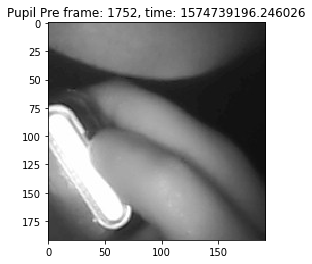

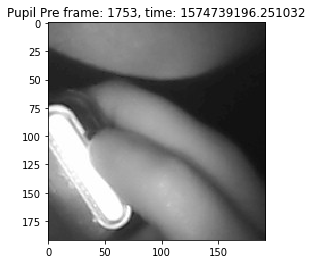

In [37]:
print(f'Target Time: {target_timestamp}')

plt.imshow(frame_pup_pre)
plt.title(f'Pupil Pre frame: {pupil_fnum-1}, time: {ts_pup_pre}')
plt.show()

plt.imshow(frame_pup)
plt.title(f'Pupil frame: {pupil_fnum}, time: {ts_pup}')
plt.show()

plt.imshow(frame_pup_post)
plt.title(f'Pupil Pre frame: {pupil_fnum+1}, time: {ts_pup_post}')
plt.show()

plt.imshow(frame_pup_post2)
plt.title(f'Pupil Pre frame: {pupil_fnum+2}, time: {ts_pup_post2}')
plt.show()

In [ ]:
n=1000 #5 seconds

xim_frame_means = []
for i in range(0,n):
    frame_xim = ana.ximea_get_frame(pupil_fnum+i, save_batchsize, 'cy', ximea_save_folder_list[0])
    xim_frame_means.append(np.mean(frame_xim))
    
pup_frame_means = ana.pupl_get_framemeans(pupil_vid_file, pupil_fnum, n)


In [ ]:
pn = pup_frame_means - np.min(pup_frame_means)
pn = pn/np.max(pn)
xn = xim_frame_means - np.min(xim_frame_means)
xn = xn/np.max(xn)
plt.plot(pn,label='pupil')
plt.plot(xn,label='ximea')
plt.legend()

In [ ]:
n=500
frame_means = np.zeros(n)
for i in range(0,n,5):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    frame_means[i] = np.mean(frame_pup)
plt.plot(frame_means)

In [ ]:
for i in range(20):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    plt.imshow(frame_pup)
    plt.show()

In [ ]:
ts = np.load(od_pupil_timestamp_path)

In [ ]:
ts.shape

In [ ]:
ts[:10]